# MNIST with vanilla Convolutional Neural Network using Tensorflow

In the previous notebook we built a simple 4-layer vanilla NN with MNIST. We saw, that this simple architecture achieved over 95% accuracy on the test dataset without much tunning (or any whatsoever). Thus, using Convolutional Neural Networks we should achive higher accuracy without much more effort. Then, we tried using CIFAR with basically the same simple architecture, achieving ~48% accuracy with 20 epochs, not so succesful.
In this notebook, we will follow two different approaches to train a CNN with CIFAR10 data. First, it will be a simpler network with low level tensorflow using tf.gradients. Then, we will improve our model using tf.keras.conv2d layers, which will take care of updating parameters for us.

In [1]:
# Import all the libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time

## Importing and preprocessing the data
We will use the CIFAR10 dataset, which we will download from Alex Krizhevsky website at University of Toronto at https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
For more details of the CIFAR10, dataset please refer to https://www.cs.toronto.edu/~kriz/cifar.html or 
Krizhevsky, A., "LearningMultipleLayersofFeaturesfromTinyImages", 2009, https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf
Since, here we will only use CIFAR10 dataset, we don't need to load MNIST.
Initially the notebook will follow a very similar style to that previously completed, likewise we will share some functions like the accuracy check and minibatch.

Furthermore, to have a cleaner notebook, we will not include all the sanity checks we used in the previous notebooks, e.g. we will not check all the data types and shapes, since we already did in the previous notebook.

In [2]:
'''
    This functions load CIFAR 10 data (from binary files inside cifar-10-python.tar.gz). Notice that the files 
    have been 'untar-ed' manually into folder specified in path. This is convenient, since it is not ideal to 
    download the data everytime we run the notebook, particularly because CIFAR10 tar file is ~170MB.

    These two functions are based on two function provided in data_utils.py in Stanford CNN for Visual 
    Recognition CS231n in (https://cs231n.github.io/assignments2019/assignment1/), and by Tensorflow cifar10.py as
    in: https://github.com/tensorflow/tensorflow/blob/r1.8/tensorflow/python/keras/_impl/keras/datasets/cifar10.py
    and https://github.com/tensorflow/tensorflow/blob/r1.8/tensorflow/python/keras/_impl/keras/datasets/cifar.py

     Inputs:
     - path: Path to CIFAR10 'untar-ed' files
     
     Outputs:
     - (x_train, y_train), (x_test, y_test): Two tuples with numpy arrays containing the train and test data 
'''
import os
from six.moves import cPickle as pickle
    
def load_CIFAR10_data(path):
    """ load all of cifar """
    data = []
    labels = []
    for b in range(1,6):
        f = os.path.join(path, 'data_batch_%d' % (b, ))
        x, y = load_CIFAR_batch(f)
        data.append(x)
        labels.append(y)
    x_train = np.concatenate(data)
    y_train = np.concatenate(labels)
    del x, y
    x_test, y_test = load_CIFAR_batch(os.path.join(path, 'test_batch'))
    return (x_train, y_train), (x_test, y_test)

def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        # Using encoding 'latin1' prevents errors with objects that may have been pickled with Python2
        d = pickle.load(f, encoding='latin1')    
        data = d['data']
        labels = d['labels']
        data = data.reshape(10000, 3, 32, 32).transpose(0,2,3,1)
        labels = np.array(labels)
        return data, labels


In [3]:
# This command allows downloading the dataset directly
(x_train, y_train), (x_test, y_test)= tf.keras.datasets.cifar10.load_data()

# Otherwise, if the data have been downloaded before, it is possible to specify the path to the data files
# and use the functions provided before
#(x_train, y_train), (x_test, y_test)= load_CIFAR10_data('/home/josh/Documents/cs231n/cifar-10-batches')

In [4]:
classes = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
              'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

In [5]:
# It is a good idea to visualise the data we just loaded.
print('Train data shape: ', x_train.shape)
print('Train labels shape: ', y_train.shape)
print('Test data shape: ', x_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (50000, 32, 32, 3)
Train labels shape:  (50000, 1)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000, 1)


Train image shape:  (32, 32, 3)
The image is a:  Truck


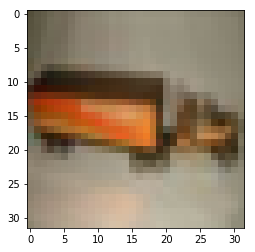

In [9]:
# So, as expected we have 50,000 training images and 10,0000 for testing. What is
# each image shape? Let's find out
print('Train image shape: ', x_train[1].shape)

# We can randomly show any of the numbers
rnd_idx = np.random.randint(x_train.shape[0])
plt.imshow(x_train[rnd_idx].astype(np.int32)) #Using astype guarantess imshow work
print('The image is a: ', classes[y_train[rnd_idx,0]])

In [10]:
# For simplicity and to use default TF settings, we cast the data to int32 and float32
# Since, the dataset is relatively small, in most cases, this is not a problem
y_train = y_train.astype(np.int32).reshape(-1)
y_test = y_test.astype(np.int32).reshape(-1)
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

In [11]:
# Here we define a function to divide our data in N mini batches, this is an important step, to allow for mini batch 
# gradient descent

def mini_batches(mini_batch_size, data_x, data_y = None):
    # First we validate the data is of the expected type, and the number of labels meet the number of training samples
    assert data_x.shape[0] == data_y.shape[0], 'X number of samples not equal to Y number of samples'
    assert (isinstance(data_x, np.ndarray) and isinstance(data_y, np.ndarray)), 'Data not numpy array'
    
    N = data_x.shape[0] # Get the number of samples
    idxs = np.arange(N) 
    # Shuffle data, this may not be so critical in this example, but it is important for most applications, to avoid
    # strong correlations in mini batches
    np.random.shuffle(idxs)
    data_x = data_x[idxs] # Shuffle training samples
    data_y = data_y[idxs] # Shuffle labels (don't forget)
    
    # Finally return the data in minibatches of the desired size
    # List comprehension is so cool, technically this is returning a generator but the principle is the same
    return ((data_x[i:i+mini_batch_size], data_y[i:i+mini_batch_size]) for i in range(0, N, mini_batch_size))

type(mini_batches(64, x_test, y_test)) # Check type returned by function

generator

## Tensorflow Low Level CNN 
In this part of the notebook, we will implement a complete CNN using Low Level TF only. I.e., we will not use those nice Keras layers. We will use 2D convolutions, with defined weights, which will be updated with tf.gradients (I mean, not that low level after all). 
For this notebokk, we will follow a simple approach where all the filters are 3x3 in size.
We will use 5-layer CNN.


In [12]:
def init_five_layer_CNN(num_filters):
    '''
    This function will be used to initialise all the learnable parameters. For simplicity all the filters
    are size 3x3.
    
    Inputs:
    - num_filters: List containing the number of filters for each layer, including the input (e.g. 3 RGB channels)
      This will have the shape [channels, k1, k2, k3, k4, classes]

    Outputs:
    - Parameters: Dictionary with network parameters, where element 'W1' and 'b1' represent weigth and bias
      for layer one
    '''
    # Dictionary  to save  parameters
    parameters = {}
        
    # Manually assing filter size 
    fsize = 3 
    
    # Number of filters
    c, k1, k2, k3, k4, classes = num_filters

    # For this architecture, we will use the more robust initialization described in:   
    #     He et al, *Delving Deep into Rectifiers: Surpassing Human-Level Performance 
    #     on ImageNet Classification, ICCV 2015, https://arxiv.org/abs/1502.01852
    
    parameters['W1'] = tf.Variable(tf.random_normal((fsize, fsize, c, k1), 
                          dtype=tf.float32) * np.sqrt(2.0 / ((32*32*c))),
                          dtype=tf.float32, name='W1')
    parameters['b1'] = tf.Variable(tf.zeros(k1, dtype=tf.float32), dtype=tf.float32, name='conv_b1')
    
    parameters['W2'] = tf.Variable(tf.random_normal((fsize, fsize, k1, k2),
                          dtype=tf.float32) * np.sqrt(2.0 / (32*32*k1)),
                          dtype=tf.float32, name='conv_w2')
    parameters['b2'] = tf.Variable(tf.zeros(k2, dtype=tf.float32), dtype=tf.float32, name='conv_b2')
    
    parameters['W3'] = tf.Variable(tf.random_normal((fsize, fsize, k2, k3), 
                          dtype=tf.float32) * np.sqrt(2.0 / (16*16*k2)),
                          dtype=tf.float32, name='conv_w3')
    parameters['b3'] = tf.Variable(tf.zeros(k3, dtype=tf.float32), dtype=tf.float32, name='conv_b3')
    
    parameters['W4'] = tf.Variable(tf.random_normal((fsize, fsize, k3, k4), 
                          dtype=tf.float32) * np.sqrt(2.0 / (16*16*k3)),
                          dtype=tf.float32, name='conv_w4')
    parameters['b4'] = tf.Variable(tf.zeros(k4, dtype=tf.float32), dtype=tf.float32, name='conv_b4')
    
    
    # If FC
    parameters['W5'] = tf.Variable(tf.random_normal((8*8*k4, classes), 
                          dtype=tf.float32) * np.sqrt(2.0 / (8*8*k4)),
                          dtype=tf.float32, name='W5')

                                               
    parameters['b5'] = tf.Variable(tf.zeros((classes), dtype=tf.float32), dtype=tf.float32, name='b5')

    
    return parameters, classes

def five_layer_CNN(x, params, classes, training=True, dropout_p=0.5):
    '''
    Create the inference graph, define the network architecture.
    Notice that Tensorflow data format is of the shape N x H x W x C
    
    Inputs:
    - x: Tensor with training or test images of shape (N, 32, 32, 3) for CIFAR10
    - params: Tuple with all the learnable weights and biases
    - classes: number of classes, i.e. the neturons in the output layer
    '''
     
    
    # We use conv2d function to apply the filter, we will use 'SAME' convolutions so that the size is keep 
    # constant, depending on max pooling for downsampling. 
    
    
    # First layer
    # The input shape is (N, H, W, C), filter shape is (fsize, fsize, C, K1)
    # The output size after the convolution is then, (N, H, W, k1)
    conv1_out = tf.nn.conv2d(input=x,
                             filter=params['W1'], 
                             strides=[1,1,1,1],
                             padding='SAME',
                             name='conv1_out')
    conv1_out += params['b1'][None, None, None, :] # Add bias, axes are added (reshape) to broadcast correctly
    conv1_out_relu = tf.nn.relu(conv1_out, name='conv1_out_relu')
    if training: conv1_out_relu = tf.nn.dropout(x=conv1_out_relu, keep_prob=dropout_p)
    
    # Second layer
    # Input shape = (N, H, W, k1), filter shape = (fsize, fsize, k1, k2)
    # Ouput shape = (N, H, W, k2)
    conv2_out = tf.nn.conv2d(input=conv1_out_relu,
                             filter=params['W2'],
                             strides=[1,1,1,1],
                             padding='SAME',
                             name='conv2_out')
    conv2_out += params['b2'][None, None, None, :] # Add bias, axes are added (reshape) to broadcast correctly
    conv2_out_relu = tf.nn.relu(conv2_out, name='conv2_out_relu')
    if training: conv2_out_relu = tf.nn.dropout(x=conv2_out_relu, keep_prob=dropout_p)
    max_pooled_layer2 = tf.nn.max_pool(value=conv2_out_relu,
                                       ksize=[1,2,2,1],
                                       strides=[1,2,2,1],
                                       padding='VALID',
                                       data_format='NHWC',
                                       name='max_pooled_layer2')
   
    # Third layer
    # Input shape = (N, 16, 16, k2), filter shape = (fsize, fsize, k2, k3)
    # Ouput shape = (N, 16, 16, k3)
    conv3_out = tf.nn.conv2d(input=max_pooled_layer2,
                             filter=params['W3'],
                             strides=[1,1,1,1],
                             padding='SAME',
                             name='conv3_out')
    conv3_out += params['b3'][None, None, None, :] # Add bias, axes are added (reshape) to broadcast correctly
    conv3_out_relu = tf.nn.relu(conv3_out, name='conv3_out_relu')
    if training: conv3_out_relu = tf.nn.dropout(x=conv3_out_relu, keep_prob=dropout_p)
                          
    # Fourth layer
    # Input shape = (N, 16, 16, k3), filter shape = (fsize, fsize, k3, k4)
    # Ouput shape = (N, 16, 16, k4)
    conv4_out = tf.nn.conv2d(input=conv3_out_relu,
                             filter=params['W4'],
                             strides=[1,1,1,1],
                             padding='SAME',
                             name='conv4_out')
    conv4_out += params['b4'][None, None, None, :] # Add bias, axes are added (reshape) to broadcast correctly
    conv4_out_relu = tf.nn.relu(conv4_out, name='conv4_out_relu')
    
    if training: conv4_out_relu = tf.nn.dropout(x=conv4_out_relu, keep_prob=dropout_p)
    
    max_pooled_layer4 = tf.nn.max_pool(value=conv4_out_relu,
                                       ksize=[1,2,2,1],
                                       strides=[1,2,2,1],
                                       padding='VALID',
                                       data_format='NHWC',
                                       name='max_pooled_layer4')
                          
    # Fifth layer
    # Input shape = (N, 8, 8, k4), filter shape = (8 x 8 k4, classes)
    # Ouput shape = (N, classes)
    scores = tf.layers.flatten(max_pooled_layer4)
    scores = tf.matmul(scores, params['W5']) + params['b5']
        
    
    return scores

Before, training our model we will use a simple test function to check if the output shape tensor matches the expected output.

In [14]:
# Help function to test if the inference graph produces the expected output dimensions given an input
# in this case the output should be of shape (N, 10)

def test_vanilla_CNN(num_samples):
    # Let us declare some useful constants
    num_filters = [3, 16, 32, 32, 64, 10]
    
    # Reset the default graph
    tf.reset_default_graph()
    
    # Define placeholder
    x = tf.placeholder(tf.float32, [None, 32, 32, 3])
    
    # Obtain parameters
    parameters, classes = init_five_layer_CNN(num_filters)
    
    # Add scores to the graph
    scores = five_layer_CNN(x, parameters, classes)
    
    # Create session and run it
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        test = sess.run(scores, feed_dict={x:x_train[:num_samples]})
        print(test.shape)

# Test our model output size
test_vanilla_CNN(15)

(15, 10)


## Building the training model
Let the fun begin! In this section we will build the trainin model.
We will use a Tensorflow session to run the inference graph and the training operations. This will look similiar to test_vanilla_CNN(), plus the required components to define a loss function and carry out learning step operations. 

In [15]:
# Let us define a function that will define the graph
def train_CNN(num_filters,
              num_epochs=10,
              learning_rate=0.05,
              reg=0.0,
              print_every=100,
              minibatch_size = 64,
              dropout_p=0.5):
    '''
    This function will be used to run our training graph by creating a Tensorflow session.
    
    Inputs:
    - num_filters: List containing the number of filters for each layer, including the input (e.g. 3 RGB channels)
      This will usually have the shape [channels, k1, k2, k3, k4, classes]
    - num_epochs: Integer with the number of epochs to run, an epoch is a complete pass in the whole training set
    - learning_rate: Float with the learning rate to use for updates, i.e. the step size towards the minimum
    - reg: L2 regularization strength, default is set to 0 for no regularization
    - print_every: This is a helping variable to stop during training and evaluate loss functions and accuracy
    - minibatch_size: Integer with the number of elements in minibatch
    
    Outputs:
    - updated_parameters: List with update parameters
    '''
    
    # Firstly, let's reset default graph.
    tf.reset_default_graph()
    
    # Then, we will define placeholdersfor the training data, we need to be careful with the shape
    x = tf.placeholder(tf.float32, [None, 32, 32, 3], name = 'x_train') # Training data
    y = tf.placeholder(tf.int32, [None, ], name = 'y_train') # Training data
    
    # Let us add the nodes to the stored graphs, 
    tf.add_to_collection('images', x)
    tf.add_to_collection('labels', y)
    
    # Let us obtain the parameters we will use to run the graph and compute the score
    parameters_dict, classes = init_five_layer_CNN(num_filters)
    
    # Add the scores
    scores = five_layer_CNN(x, parameters_dict, classes, dropout_p=dropout_p)
    
    # Add forward pass node
    scores_test = five_layer_CNN(x, parameters_dict, classes,training=False)
    
    # Before moving on, save the scores so that we can run the graph from a restore
    tf.add_to_collection('scores', scores)
    
    # Once the scores have been computed, we need to calculate our loss function (or error function)
    # This will allow us to estimate how far we are from the true value
#     losses = tf.contrib.kernel_methods.sparse_multiclass_hinge_loss(labels=y, logits=scores)
    
    losses = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = scores, labels=y)
    data_loss = tf.reduce_mean(losses, name='data_loss') # In case we use regularisation on our weights
    
    # Add L2 regularisation, this will be a bit tedious
    reg_loss = tf.reduce_mean(reg * (tf.nn.l2_loss(parameters_dict['W1']) #Check if reducing mean is needed
               + tf.nn.l2_loss(parameters_dict['W2'])
               + tf.nn.l2_loss(parameters_dict['W3'])
               + tf.nn.l2_loss(parameters_dict['W4']) 
               + tf.nn.l2_loss(parameters_dict['W5'])))
    
    # Calculate total loss
    loss = data_loss + reg_loss
                 
    # Now we need to use Tensorflow magic to calculate the gradients, remember that is still a bit of Low level
    # tensorflow
    # first, we need to convert the parameters dictionary to list
    parameters = [(param) for (key, param) in parameters_dict.items()]
        
    parameter_gradients = tf.gradients(loss, parameters)

    # We need to update the weights manually, for this we can use tf.assign, or tf.assing_sub
    # Using SGD, we need to update each parameter independently, so list comprehension works well
    updated_parameters = [tf.assign_sub(w, learning_rate * grad) 
                          for w, grad in zip(parameters, parameter_gradients)]
    
   
    # Save gradients
    tf.add_to_collection('weights', updated_parameters)
    
    # Create saver to save the model
    saver = tf.train.Saver()
    
    # Helping variables to save useful information
    best_acc = 0.0
    accuracies = np.zeros((int(x_train.shape[0]/minibatch_size/print_every)) + 1)
    # Now, recall we have only created the graph, in order to run it and train, we need a Session
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch in range(num_epochs):
            print('Starting epoch: ', epoch)
            for iteration, (x_mb, y_mb) in enumerate(mini_batches(minibatch_size, x_train, y_train)):
                # The following line runs the loss for the minibatch.
                # Recall TF knows what is needed to run a function and will run accordingy, e.g. scores before the
                # loss. Also note that we only need to feed the data needed into a placeholder. In this case, we 
                # feed the minibatch training samples and labels
                loss_mb, update_param = sess.run([loss, updated_parameters], feed_dict={x:x_mb, y:y_mb})
                
                if iteration % print_every == 0:
                    # We define this function in the next cell
                    accuracy = compute_accuracy(sess, minibatch_size, scores_test, x)
                    accuracies[int(iteration/100)]=accuracy # save current accuracy
#                     losses[int(iteration/print_every)] = loss_mb
                    if accuracy > best_acc:
                        best_acc = accuracy
                    print('Iteration: %d Loss: %f Accuracy: %f Learning rate: %f Regularization: %f'
                          %(iteration, loss_mb, accuracy, learning_rate, reg))
            
            acc_range = np.max(accuracies) - np.min(accuracies)
            print('Accuracies mean: %f Accuracies std: %f Range: %f' %(np.mean(accuracies), np.std(accuracies),
                                                            acc_range))
#             if (acc_range < 0.10):
#                 learning_rate = 0.90 * learning_rate
            
        saver.save(sess, 'checkpoint_file')
        print('Best accuracy: %f', best_acc)

        
    return update_param, best_acc

In [16]:
def compute_accuracy(sess, minibatch_size, scores, x):
    '''
    This function computes the accuracy of the current model
    
    Inputs:
    - sess: it needs a current tf.Session to run the scores
    - minibatch_size: The size of the mini batch to run the scores
    - scores: TF operation to run
    - x: test data
    
    Outputs:
    - acc: Accuracy
    
    '''
    num_samples = 0
    num_correct = 0
    for it, (xtest_mb, ytest_mb) in enumerate(mini_batches(minibatch_size, x_test, y_test)):
        scores_test = sess.run(scores, feed_dict={x:xtest_mb})
        y_pred = np.argmax(scores_test, axis=1)

#         In case we would like to compare some elements of the predicted and ground truth arrays
#         if it % 200 == 0:
#             print('y_pred: ', y_pred[:10])
#             print('y_test: ', ytest_mb[:10])

        num_samples += xtest_mb.shape[0]
        num_correct += np.sum(np.equal(y_pred, ytest_mb))
    acc = float(num_correct) / num_samples
    return acc

In [17]:
# Let us train! We should expect achieving better perfomance than that we achieved with the fully connected
# network in previous experiment. Here, we will experiment with hyperparameter selection
num_filters = [3, 32, 64, 64, 128, 10]

#10e-3 if random init with std = 0.01
# Let us try for 10 combinations of regularization and learning rates
total_tests = 5
num_epochs = 10
accuracies = {}
for test in range(total_tests):
    learning_rate = 10**np.random.uniform(-4, -1)
    reg = 10**np.random.uniform(-5.5, -2.5)
    update_param, best_acc = train_CNN(
                num_filters,
                num_epochs=num_epochs,
                learning_rate=learning_rate, 
                reg=reg,
                print_every=100,
                minibatch_size = 64, 
                dropout_p=1.0)
    accuracies[(learning_rate, reg)] = best_acc
    print('Accuracy with LR=%f and Reg=%f ---> %f' %(learning_rate, reg, best_acc))

accs = sorted([(acc, lr_reg )for lr_reg, acc in accuracies.items()], reverse=1)
print('Best acc after %d epochs: %f with lr: %e and reg: %f' 
      %(num_epochs, accs[0][0], accs[0][1][0], accs[0][1][1]))

Starting epoch:  0
Iteration: 0 Loss: 2.322904 Accuracy: 0.102600 Learning rate: 0.001850 Regularization: 0.000337
Iteration: 100 Loss: 2.288781 Accuracy: 0.103900 Learning rate: 0.001850 Regularization: 0.000337
Iteration: 200 Loss: 2.200064 Accuracy: 0.170400 Learning rate: 0.001850 Regularization: 0.000337
Iteration: 300 Loss: 2.013342 Accuracy: 0.245500 Learning rate: 0.001850 Regularization: 0.000337
Iteration: 400 Loss: 1.967280 Accuracy: 0.312600 Learning rate: 0.001850 Regularization: 0.000337
Iteration: 500 Loss: 2.075110 Accuracy: 0.301900 Learning rate: 0.001850 Regularization: 0.000337
Iteration: 600 Loss: 1.820794 Accuracy: 0.338400 Learning rate: 0.001850 Regularization: 0.000337
Iteration: 700 Loss: 1.776026 Accuracy: 0.356000 Learning rate: 0.001850 Regularization: 0.000337
Accuracies mean: 0.241413 Accuracies std: 0.096502 Range: 0.253400
Starting epoch:  1
Iteration: 0 Loss: 1.943289 Accuracy: 0.327700 Learning rate: 0.001850 Regularization: 0.000337
Iteration: 100 Lo

Iteration: 400 Loss: 0.815536 Accuracy: 0.637100 Learning rate: 0.001850 Regularization: 0.000337
Iteration: 500 Loss: 1.258722 Accuracy: 0.645600 Learning rate: 0.001850 Regularization: 0.000337
Iteration: 600 Loss: 0.936822 Accuracy: 0.650900 Learning rate: 0.001850 Regularization: 0.000337
Iteration: 700 Loss: 1.016031 Accuracy: 0.642000 Learning rate: 0.001850 Regularization: 0.000337
Accuracies mean: 0.642512 Accuracies std: 0.004484 Range: 0.013800
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'
Best accuracy: %f 0.6509
Accuracy with LR=0.001850 and Reg=0.000337 ---> 0.650900
Starting epoch:  0
Iteration: 0 Loss: 2.299997 Accuracy: 0.094900 Learning rate: 0.000167 Regularization: 0.000016
Iteration: 100 Loss: 2.305932 Accuracy: 0.124500 Learning rate: 0.000167 Regularization: 0.000016
Iteration: 200 Loss: 2.299893 Accuracy: 0.132200 Learning rate: 0.00

Iteration: 500 Loss: 1.460048 Accuracy: 0.425700 Learning rate: 0.000167 Regularization: 0.000016
Iteration: 600 Loss: 1.616174 Accuracy: 0.431200 Learning rate: 0.000167 Regularization: 0.000016
Iteration: 700 Loss: 1.828131 Accuracy: 0.434200 Learning rate: 0.000167 Regularization: 0.000016
Accuracies mean: 0.423238 Accuracies std: 0.007088 Range: 0.022100
Starting epoch:  9
Iteration: 0 Loss: 1.531688 Accuracy: 0.430200 Learning rate: 0.000167 Regularization: 0.000016
Iteration: 100 Loss: 1.511013 Accuracy: 0.426700 Learning rate: 0.000167 Regularization: 0.000016
Iteration: 200 Loss: 1.777067 Accuracy: 0.438600 Learning rate: 0.000167 Regularization: 0.000016
Iteration: 300 Loss: 1.473734 Accuracy: 0.432300 Learning rate: 0.000167 Regularization: 0.000016
Iteration: 400 Loss: 2.023827 Accuracy: 0.422600 Learning rate: 0.000167 Regularization: 0.000016
Iteration: 500 Loss: 1.564401 Accuracy: 0.439900 Learning rate: 0.000167 Regularization: 0.000016
Iteration: 600 Loss: 1.640178 Accu

Iteration: 600 Loss: 0.963944 Accuracy: 0.633300 Learning rate: 0.041342 Regularization: 0.000017
Iteration: 700 Loss: 0.794537 Accuracy: 0.620800 Learning rate: 0.041342 Regularization: 0.000017
Accuracies mean: 0.608550 Accuracies std: 0.024898 Range: 0.085000
Starting epoch:  8
Iteration: 0 Loss: 0.921699 Accuracy: 0.624900 Learning rate: 0.041342 Regularization: 0.000017
Iteration: 100 Loss: 0.999224 Accuracy: 0.610100 Learning rate: 0.041342 Regularization: 0.000017
Iteration: 200 Loss: 1.043718 Accuracy: 0.635100 Learning rate: 0.041342 Regularization: 0.000017
Iteration: 300 Loss: 0.602070 Accuracy: 0.644600 Learning rate: 0.041342 Regularization: 0.000017
Iteration: 400 Loss: 0.708678 Accuracy: 0.615400 Learning rate: 0.041342 Regularization: 0.000017
Iteration: 500 Loss: 1.419067 Accuracy: 0.618500 Learning rate: 0.041342 Regularization: 0.000017
Iteration: 600 Loss: 0.797740 Accuracy: 0.623600 Learning rate: 0.041342 Regularization: 0.000017
Iteration: 700 Loss: 1.087325 Accu

Iteration: 700 Loss: 1.886645 Accuracy: 0.356900 Learning rate: 0.000133 Regularization: 0.000006
Accuracies mean: 0.340762 Accuracies std: 0.008454 Range: 0.025100
Starting epoch:  7
Iteration: 0 Loss: 1.969300 Accuracy: 0.349200 Learning rate: 0.000133 Regularization: 0.000006
Iteration: 100 Loss: 1.920740 Accuracy: 0.356200 Learning rate: 0.000133 Regularization: 0.000006
Iteration: 200 Loss: 1.928621 Accuracy: 0.357800 Learning rate: 0.000133 Regularization: 0.000006
Iteration: 300 Loss: 1.675707 Accuracy: 0.359200 Learning rate: 0.000133 Regularization: 0.000006
Iteration: 400 Loss: 1.715910 Accuracy: 0.364400 Learning rate: 0.000133 Regularization: 0.000006
Iteration: 500 Loss: 1.957980 Accuracy: 0.361900 Learning rate: 0.000133 Regularization: 0.000006
Iteration: 600 Loss: 1.898578 Accuracy: 0.361400 Learning rate: 0.000133 Regularization: 0.000006
Iteration: 700 Loss: 1.931885 Accuracy: 0.370800 Learning rate: 0.000133 Regularization: 0.000006
Accuracies mean: 0.360113 Accuraci

Accuracies mean: 0.701500 Accuracies std: 0.016566 Range: 0.046200
Starting epoch:  6
Iteration: 0 Loss: 0.620006 Accuracy: 0.702700 Learning rate: 0.014032 Regularization: 0.001462
Iteration: 100 Loss: 0.436950 Accuracy: 0.725800 Learning rate: 0.014032 Regularization: 0.001462
Iteration: 200 Loss: 0.473519 Accuracy: 0.709900 Learning rate: 0.014032 Regularization: 0.001462
Iteration: 300 Loss: 0.651775 Accuracy: 0.718600 Learning rate: 0.014032 Regularization: 0.001462
Iteration: 400 Loss: 0.805248 Accuracy: 0.714300 Learning rate: 0.014032 Regularization: 0.001462
Iteration: 500 Loss: 0.649656 Accuracy: 0.721100 Learning rate: 0.014032 Regularization: 0.001462
Iteration: 600 Loss: 0.751462 Accuracy: 0.716700 Learning rate: 0.014032 Regularization: 0.001462
Iteration: 700 Loss: 0.612254 Accuracy: 0.726700 Learning rate: 0.014032 Regularization: 0.001462
Accuracies mean: 0.716975 Accuracies std: 0.007526 Range: 0.024000
Starting epoch:  7
Iteration: 0 Loss: 0.604606 Accuracy: 0.708100

In [ ]:
# From the previous result, we see that the best accuracy is with LR = 1.679e-02, thus we can look in a finer
# interval, e.g. 10**[-2, -1.5]
# since Reg = 0.000005, let us look in the interval [-5.5, -4.5]
# Then in this step, we will look in narrower interval to fine tune the LR and Reg values.

# Let us try for 10 combinations of regularization and learning rates
total_tests = 5
num_epochs = 10
accuracies = {}
for test in range(total_tests):
    learning_rate = 10**np.random.uniform(-2.5, -1.5)
    reg = 10**np.random.uniform(-5, -4)
    update_param, best_acc = train_CNN(
                num_filters,
                num_epochs=num_epochs,
                learning_rate=learning_rate, 
                reg=reg,
                print_every=100,
                minibatch_size = 64, 
                dropout_p=1.0)
    accuracies[(learning_rate, reg)] = best_acc
    print('Accuracy with LR=%f and Reg=%f ---> %f' %(learning_rate, reg, best_acc))

accs = sorted([(acc, lr_reg )for lr_reg, acc in accuracies.items()], reverse=1)
print('Best acc after %d epochs: %f with lr: %e and reg: %f' 
      %(num_epochs, accs[0][0], accs[0][1][0], accs[0][1][1]))

The predicted class is:  Frog
The correct class is:  Frog


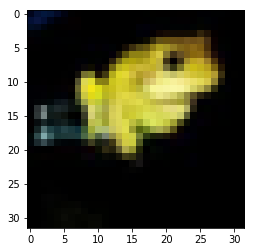

In [87]:
# Firstly, we create the placeholder that will receive the test data
x = tf.placeholder(tf.float32, [1, 32, 32, 3])


# Since we used a dictionary instead of a list for storing the parameters, but the training routine returns
# a list, we first convert manually the list into a dictionary
update_params = {}
list_of_keys = ['W1', 'b1', 'W2', 'b2', 'W3', 'b3', 'W4', 'b4', 'W5','b5']
update_params = {key : update_param[i] for i,key in enumerate(list_of_keys)}


# We then, call the fordward function
scores = five_layer_CNN(x=x, params=update_params, classes=10 ,training=False)

idx = np.random.randint(10000)

# Let's now create run the prediction graph
with tf.Session() as sess2:
    sess2.run(tf.global_variables_initializer())
    scores2 = sess2.run(scores, feed_dict={x:x_test[idx].reshape(1, 32, 32, 3)})
    
    print('The predicted class is: ', classes[np.argmax(scores2)])
    print('The correct class is: ', classes[y_test[idx]])
    
    plt.imshow(x_test[idx].astype(np.int32))
    


In [71]:
update_params = {}
list_of_keys = ['W1', 'b1', 'W2', 'b2', 'W3', 'b3', 'W4', 'b4', 'W5','b5']

for i,key in enumerate(list_of_keys):
    update_params[key] = update_param[i]
